In [10]:
import pandas as pd 
import matplotlib.pyplot as plt

## Knowing the Dataset

De acuerdo al requerimiento: 

"pronosticar las ventas para los siguientes 7 días desde el final del histórico de datos, tenga en cuenta que la fecha de la venta se encuentra en la variable “saletime” y que esta está mostrada a una granularidad de factura individual", 

se entiende que las variables de interés se encuentra en la base de datos sales_tab.txt, específicamente la cantidad de ventas y la fecha de la venta.

In [11]:
pathsales = ".\..\..\dataset\sales_tab.txt"
sales = pd.read_csv(pathsales, sep='\t', header = None, encoding= 'utf-8')
sales.columns =['salesid','listid','sellerid','buyerid','eventid','dateid','qtysold','pricepaid','commission','saletime']
sales.head()

,salesid,listid,sellerid,buyerid,eventid,dateid,qtysold,pricepaid,commission,saletime
0,1,1,36861,21191,7872,1875,4,728,109.20,2/18/2008 02:36:48
1,2,4,8117,11498,4337,1983,2,76,11.40,6/6/2008 05:00:16
2,3,5,1616,17433,8647,1983,2,350,52.50,6/6/2008 08:26:17
3,4,5,1616,19715,8647,1986,1,175,26.25,6/9/2008 08:38:52
4,5,6,47402,14115,8240,2069,2,154,23.10,8/31/2008 09:17:02


* qtysold: The number of tickets that were sold, from 1 to 8. (A maximum of 8 tickets can be sold in a single transaction.)
* saletime: The full date and time when the sale was completed, such as 2008-05-24 06:21:47.

In [12]:
data = sales[['qtysold', 'saletime']]
data.head()

,qtysold,saletime
0,4,2/18/2008 02:36:48
1,2,6/6/2008 05:00:16
2,2,6/6/2008 08:26:17
3,1,6/9/2008 08:38:52
4,2,8/31/2008 09:17:02


Preprocessing data: Data preparation

In [13]:
data['saletime'] = pd.to_datetime(data['saletime'])
data['saletime'] = data['saletime'].dt.strftime('%Y-%m-%d')
data['saletime'] = data['saletime'].astype('datetime64[ns]')
data = data.set_index('saletime')
data = data.sort_index()
data.head()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_760\3791050964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['saletime'] = pd.to_datetime(data['saletime'])
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_760\3791050964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['saletime'] = data['saletime'].dt.strftime('%Y-%m-%d')
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_760\3791050964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,qtysold
saletime,
2008-01-01,4
2008-01-01,2
2008-01-01,1
2008-01-01,4
2008-01-01,2


In [14]:
print("initial saletime:", data.index.min())
print("end saletime:", data.index.max())

initial saletime: 2008-01-01 00:00:00
end saletime: 2008-12-31 00:00:00


In [15]:
# daily sales 
daily = data.resample('D').sum()
daily.head()

,qtysold
saletime,
2008-01-01,19
2008-01-02,57
2008-01-03,94
2008-01-04,157
2008-01-05,210


In [21]:
# Monthly sales
monthly = data.resample('M').sum()
monthly.head()

,qtysold
saletime,
2008-01-31,15306
2008-02-29,28528
2008-03-31,32840
2008-04-30,30827
2008-05-31,32291


## Examine and Prepare the Dataset for Modeling

It’s important to check any time series data for patterns that can affect the results, and can inform which forecasting model to use. Some common time series data patterns are:

* Level: the average value in the series
* Trend: Increase, decrease or stays
* Seasonal or periodic: Pattern repeats periodically over the time
* Cyclical: Pattern that increases and decreases but usually related to non-seasonal activity, like business cycles
* Random or Irregular Variations: Increases and decreases that don’t have any apparent pattern

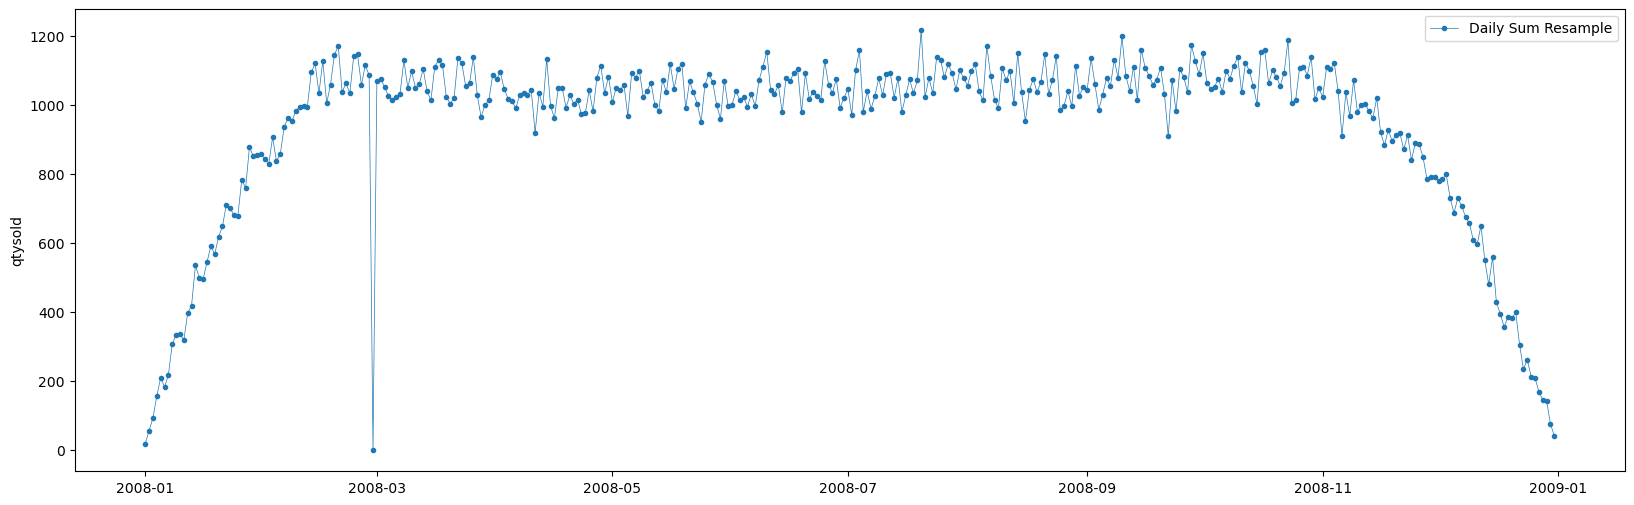

In [23]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(daily, marker='.', linestyle='-', linewidth=0.5, label='Daily Sum Resample')
ax.set_ylabel('qtysold')
ax.legend()

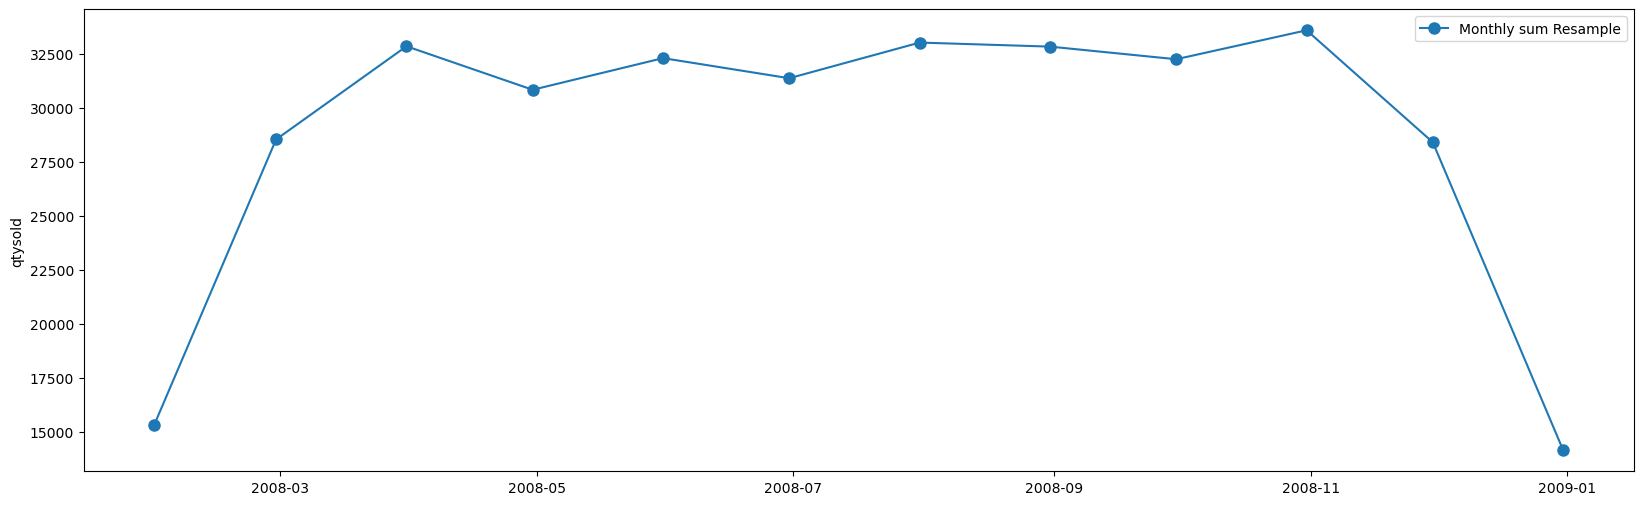

In [24]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(monthly, marker='o', markersize=8, linestyle='-', label='Monthly sum Resample')
ax.set_ylabel('qtysold')
ax.legend()

By looking at the graph of sales data above, we can see a general increasing, stay and finally decrease trend with no clear pattern of seasonal or cyclical changes. The next step is to decompose the data to view more of the complexity behind the linear visualization. A useful Python function called seasonal_decompose within the 'statsmodels' package can help us to decompose the data into four different components:

* Observed
* Trended
* Seasonal
* Residual

In [25]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose(y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

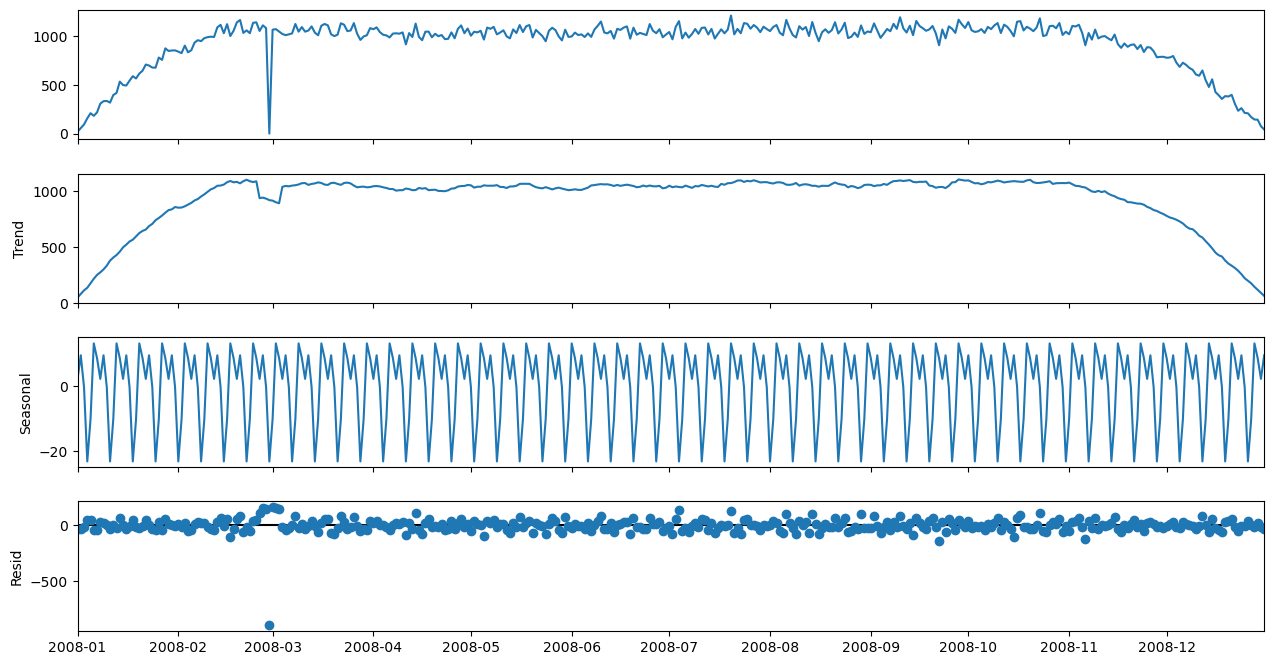

In [27]:
seasonal_decompose(daily)


Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

In [29]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [30]:
ADF_test(daily,'raw data')


 > Is the raw data stationary ?
Test statistic = 0.410
P-value = 0.982
Critical values :
	1%: -3.4491725955218655 - The data is not stationary with 99% confidence
	5%: -2.8698334971428574 - The data is not stationary with 95% confidence
	10%: -2.5711883591836733 - The data is not stationary with 90% confidence


This method removes the underlying trend in the time series:

In [31]:
# Detrending
y_detrend =  (daily - daily.rolling(window=4).mean())/daily.rolling(window=4).std()



This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 7-days seasonality, I used a 7-lag difference:

In [35]:
# Differencing
y_7lag =  daily - daily.shift(7)


In [36]:
# Detrending + Differencing

y_7lag_detrend =  y_detrend - y_detrend.shift(7)

ADF_test(y_7lag_detrend,'7 lag differenced de-trended data')

 > Is the 7 lag differenced de-trended data stationary ?
Test statistic = -8.038
P-value = 0.000
Critical values :
	1%: -3.4497304638968043 - The data is  stationary with 99% confidence
	5%: -2.8700785273763487 - The data is  stationary with 95% confidence
	10%: -2.571319005190311 - The data is  stationary with 90% confidence


Using the combination of the two methods, we see from the ADF test that the data is now stationary. This is the transformation we will use moving forward with our analysis.